<a href="https://colab.research.google.com/github/GaneshReddy2232/DauNet/blob/main/Copy_of_SegNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()  # upload your kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
!kaggle datasets download -d pratikjadhav05/kidney-segmentation-dataset -p /content/data --unzip

Dataset URL: https://www.kaggle.com/datasets/pratikjadhav05/kidney-segmentation-dataset
License(s): unknown
  0% 0.00/65.6M [00:00<?, ?B/s]
100% 65.6M/65.6M [00:00<00:00, 1.00GB/s]


In [3]:
!pip install torchvision
import os, cv2, glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [4]:
def load_data(img_dir, mask_dir, img_size=(256, 256)):
    images, masks = [], []
    for img_path in glob.glob(os.path.join(img_dir, "*.png")):
        filename = os.path.basename(img_path)
        mask_path = os.path.join(mask_dir, filename)

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if img is None or mask is None:
            continue

        img = cv2.resize(img, img_size)
        mask = cv2.resize(mask, img_size)

        images.append(img / 255.0)
        masks.append(mask / 255.0)

    return np.array(images), np.array(masks)

In [5]:
images, masks = load_data("/content/data/images", "/content/data/masks")

In [6]:
images = images[..., np.newaxis]
masks = masks[..., np.newaxis]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=42)

In [8]:
train_count = len(X_train)
test_count = len(X_test)
total_count = train_count + test_count

train_pct = (train_count / total_count) * 100
test_pct = (test_count / total_count) * 100

print(f"Total images: {total_count}")
print(f"Training set: {train_count} images ({train_pct:.1f}%)")
print(f"Testing set:  {test_count} images ({test_pct:.1f}%)")

Total images: 2027
Training set: 1621 images (80.0%)
Testing set:  406 images (20.0%)


In [9]:
import matplotlib.pyplot as plt

def show_samples(images, masks, title="Samples", num=3):
    plt.figure(figsize=(num * 4, 4))
    for i in range(num):
        img = images[i].squeeze()
        mask = masks[i].squeeze()

        plt.subplot(2, num, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"{title} Image {i+1}")
        plt.axis('off')

        plt.subplot(2, num, i + 1 + num)
        plt.imshow(mask, cmap='gray')
        plt.title(f"{title} Mask {i+1}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()


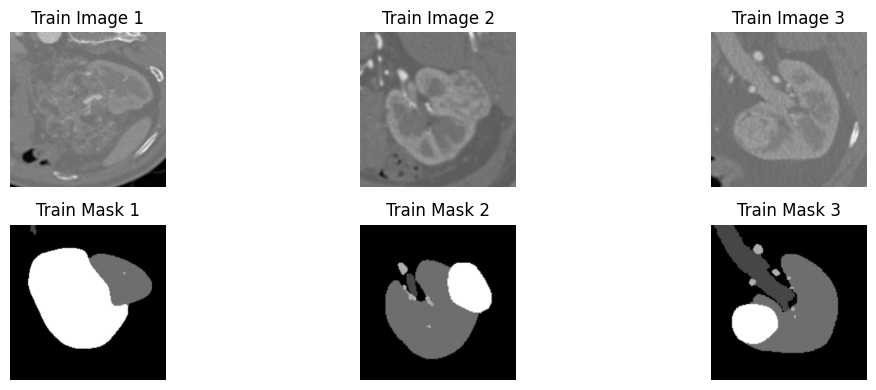

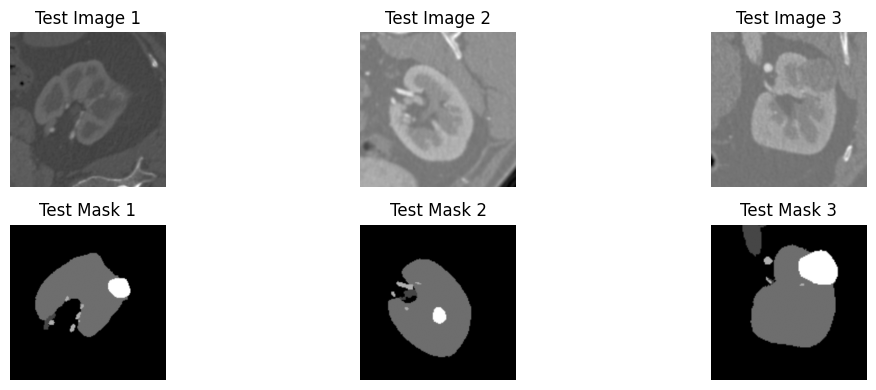

In [10]:
show_samples(X_train, y_train, title="Train", num=3)
show_samples(X_test, y_test, title="Test", num=3)

In [11]:
class KidneyDataset(Dataset):
    def __init__(self, images, masks):
        self.images = torch.tensor(images, dtype=torch.float32).permute(0, 3, 1, 2)
        self.masks = torch.tensor(masks, dtype=torch.float32).permute(0, 3, 1, 2)

    def __len__(self): return len(self.images)
    def __getitem__(self, idx): return self.images[idx], self.masks[idx]

train_ds = KidneyDataset(X_train, y_train)
test_ds = KidneyDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=4)


In [12]:
class SegNet(nn.Module):
    def __init__(self):
        super(SegNet, self).__init__()

        # Encoder
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
        )
        self.pool1 = nn.MaxPool2d(2, 2, return_indices=True)  # 128x128

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
        )
        self.pool2 = nn.MaxPool2d(2, 2, return_indices=True)  # 64x64

        # Decoder
        self.unpool2 = nn.MaxUnpool2d(2, 2)
        self.deconv2 = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
        )

        self.unpool1 = nn.MaxUnpool2d(2, 2)
        self.deconv1 = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, 3, padding=1), nn.Sigmoid()
        )

    def forward(self, x):
        # Encoder
        x = self.conv1(x)
        x, idx1 = self.pool1(x)

        x = self.conv2(x)
        x, idx2 = self.pool2(x)

        # Decoder
        x = self.unpool2(x, idx2)
        x = self.deconv2(x)

        x = self.unpool1(x, idx1)
        x = self.deconv1(x)

        return x


In [13]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm  # live progress bar

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SegNet().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

epoch_losses = []

for epoch in range(20):
    model.train()
    total_loss = 0

    print(f"\n Epoch {epoch+1}/20")
    batch_bar = tqdm(train_loader, desc="Training", leave=False)

    for imgs, masks in batch_bar:
        imgs, masks = imgs.to(device), masks.to(device)
        preds = model(imgs)
        loss = criterion(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        batch_bar.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(train_loader)
    epoch_losses.append(avg_loss)
    print(f"Epoch {epoch+1} Avg Loss: {avg_loss:.4f}")



 Epoch 1/20


Training:   0%|          | 0/406 [00:00<?, ?it/s]

Epoch 1 Avg Loss: 0.5339

 Epoch 2/20


Training:   0%|          | 0/406 [00:00<?, ?it/s]

Epoch 2 Avg Loss: 0.5229

 Epoch 3/20


Training:   0%|          | 0/406 [00:00<?, ?it/s]

Epoch 3 Avg Loss: 0.5194

 Epoch 4/20


Training:   0%|          | 0/406 [00:00<?, ?it/s]

Epoch 4 Avg Loss: 0.5155

 Epoch 5/20


Training:   0%|          | 0/406 [00:00<?, ?it/s]

Epoch 5 Avg Loss: 0.5137

 Epoch 6/20


Training:   0%|          | 0/406 [00:00<?, ?it/s]

Epoch 6 Avg Loss: 0.5118

 Epoch 7/20


Training:   0%|          | 0/406 [00:00<?, ?it/s]

Epoch 7 Avg Loss: 0.5105

 Epoch 8/20


Training:   0%|          | 0/406 [00:00<?, ?it/s]

Epoch 8 Avg Loss: 0.5097

 Epoch 9/20


Training:   0%|          | 0/406 [00:00<?, ?it/s]

Epoch 9 Avg Loss: 0.5086

 Epoch 10/20


Training:   0%|          | 0/406 [00:00<?, ?it/s]

Epoch 10 Avg Loss: 0.5084

 Epoch 11/20


Training:   0%|          | 0/406 [00:00<?, ?it/s]

Epoch 11 Avg Loss: 0.5072

 Epoch 12/20


Training:   0%|          | 0/406 [00:00<?, ?it/s]

Epoch 12 Avg Loss: 0.5071

 Epoch 13/20


Training:   0%|          | 0/406 [00:00<?, ?it/s]

Epoch 13 Avg Loss: 0.5062

 Epoch 14/20


Training:   0%|          | 0/406 [00:00<?, ?it/s]

Epoch 14 Avg Loss: 0.5055

 Epoch 15/20


Training:   0%|          | 0/406 [00:00<?, ?it/s]

Epoch 15 Avg Loss: 0.5052

 Epoch 16/20


Training:   0%|          | 0/406 [00:00<?, ?it/s]

Epoch 16 Avg Loss: 0.5048

 Epoch 17/20


Training:   0%|          | 0/406 [00:00<?, ?it/s]

Epoch 17 Avg Loss: 0.5045

 Epoch 18/20


Training:   0%|          | 0/406 [00:00<?, ?it/s]

Epoch 18 Avg Loss: 0.5040

 Epoch 19/20


Training:   0%|          | 0/406 [00:00<?, ?it/s]

Epoch 19 Avg Loss: 0.5033

 Epoch 20/20


Training:   0%|          | 0/406 [00:00<?, ?it/s]

Epoch 20 Avg Loss: 0.5033


Text(0.5, 1.0, 'Prediction')

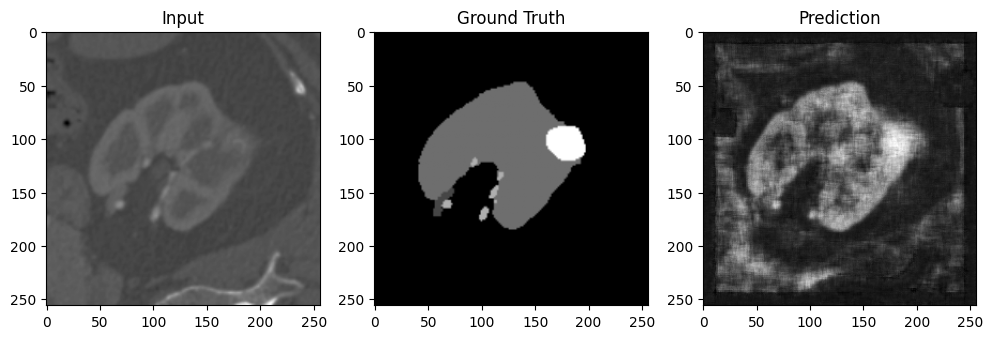

In [14]:
model.eval()
with torch.no_grad():
    test_img, test_mask = test_ds[0]
    test_img_input = test_img.unsqueeze(0).to(device)
    pred_mask = model(test_img_input).squeeze().cpu().numpy()

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1); plt.imshow(test_img.squeeze(), cmap='gray'); plt.title("Input")
plt.subplot(1, 3, 2); plt.imshow(test_mask.squeeze(), cmap='gray'); plt.title("Ground Truth")
plt.subplot(1, 3, 3); plt.imshow(pred_mask, cmap='gray'); plt.title("Prediction")


In [15]:
def compute_iou(pred, target, threshold=0.5):
    pred = pred > threshold
    target = target > threshold
    intersection = (pred & target).sum()
    union = (pred | target).sum()
    if union == 0:
        return 1.0 if intersection == 0 else 0.0
    return intersection / union

def compute_dice(pred, target, threshold=0.5):
    pred = pred > threshold
    target = target > threshold
    intersection = (pred & target).sum()
    return (2. * intersection) / (pred.sum() + target.sum() + 1e-8)

def compute_pixel_accuracy(pred, target, threshold=0.5):
    pred = pred > threshold
    target = target > threshold
    correct = (pred == target).sum()
    total = pred.size
    return correct / total


In [16]:
model.eval()

total_iou = 0.0
total_dice = 0.0
total_acc = 0.0
num_samples = len(test_ds)

with torch.no_grad():
    for i in range(num_samples):
        img, true_mask = test_ds[i]
        img = img.unsqueeze(0).to(device)  # [1, 1, H, W]
        pred_mask = model(img).squeeze().cpu().numpy()
        true_mask = true_mask.squeeze().numpy()

        total_iou += compute_iou(pred_mask, true_mask)
        total_dice += compute_dice(pred_mask, true_mask)
        total_acc += compute_pixel_accuracy(pred_mask, true_mask)

avg_iou = total_iou / num_samples
avg_dice = total_dice / num_samples
avg_acc = total_acc / num_samples

print(f"Test Set Metrics:")
print(f"Pixel Accuracy: {avg_acc*100:.4f}")
print(f"Dice Coefficient: {avg_dice*100:.4f}")
print(f"IoU: {avg_iou*100:.4f}")


Test Set Metrics:
Pixel Accuracy: 86.0620
Dice Coefficient: 18.7955
IoU: 11.5549


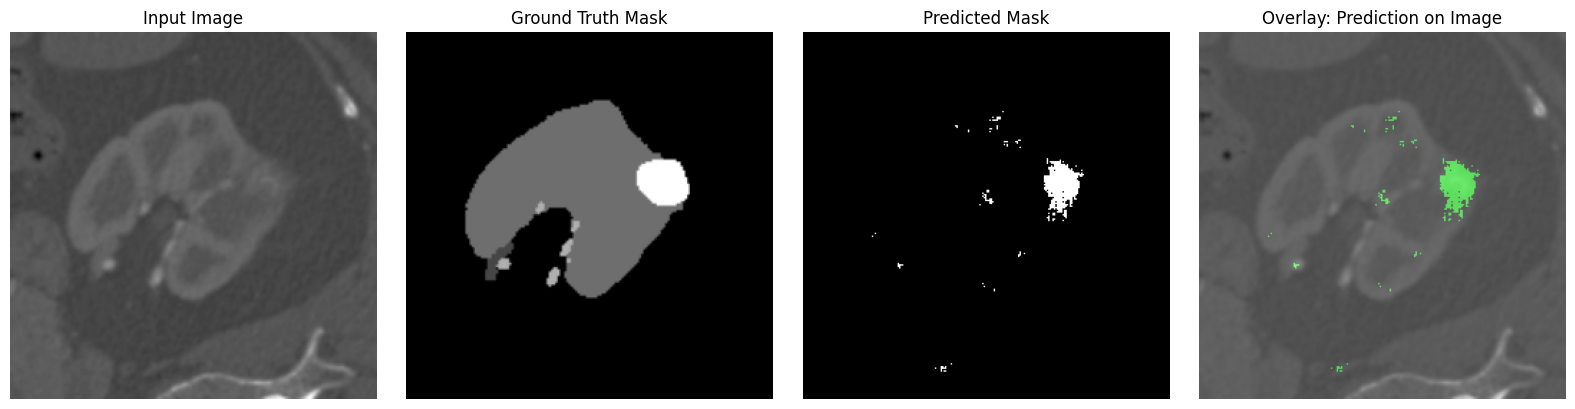

In [17]:
import matplotlib.pyplot as plt
import numpy as np

model.eval()
idx = 0  # You can loop this for multiple test images

with torch.no_grad():
    test_img, test_mask = test_ds[idx]
    input_tensor = test_img.unsqueeze(0).to(device)
    pred_mask = model(input_tensor).squeeze().cpu().numpy()
    input_img = test_img.squeeze().numpy()
    ground_truth = test_mask.squeeze().numpy()

# Convert prediction to binary
binary_pred = (pred_mask > 0.5).astype(np.uint8)

# Overlay prediction on original image
overlay = np.stack([input_img]*3, axis=-1)  # Convert grayscale to RGB
overlay[..., 1] += binary_pred * 0.5  # Highlight predicted area in green
overlay = np.clip(overlay, 0, 1)

# Plot all
plt.figure(figsize=(16, 4))

plt.subplot(1, 4, 1)
plt.imshow(input_img, cmap='gray')
plt.title("Input Image")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(ground_truth, cmap='gray')
plt.title("Ground Truth Mask")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(binary_pred, cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(overlay)
plt.title("Overlay: Prediction on Image")
plt.axis('off')

plt.tight_layout()
plt.show()
